In [1]:
import cv2
import numpy as np

In [2]:
real_points_poses_mm = [[0,0], [95, 0], [144.3, 136.574], [-49.3, 136.574]]
real_points_poses_mm = np.asarray(real_points_poses_mm)

In [3]:
img_pts = [[941 + 100/2, 690 + 111/2], [1929 + 104/2, 696 + 106/2], [2410 + 103/2, 2136 + 106/2], [443 + 89/2, 2107 + 102/2]]
img_pts = np.float32(img_pts)

In [4]:
# order of points in real_points_poses_mm and img_pts MATTERS

In [5]:
for r_pt, im_pt in zip(real_points_poses_mm, img_pts):
    print(f'obj pt \t {r_pt} -> {im_pt} \t image pt')

obj pt 	 [0. 0.] -> [991.  745.5] 	 image pt
obj pt 	 [95.  0.] -> [1981.  749.] 	 image pt
obj pt 	 [144.3   136.574] -> [2461.5 2189. ] 	 image pt
obj pt 	 [-49.3   136.574] -> [ 487.5 2158. ] 	 image pt


In [6]:
img = cv2.imread('/Users/aleksandrrybnikov/Downloads/IMG_20230422_095640.jpg')

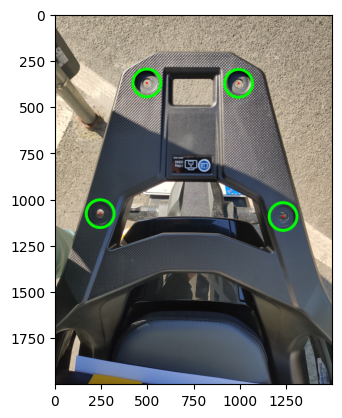

In [7]:
# draw the points
img_to_show = np.copy(img)

for pt in img_pts:
    cv2.circle(img_to_show, np.int32(pt), np.min(img_to_show.shape[:2]) // 20, (0, 255, 0), max(5, np.min(img_to_show.shape[:2]) // 100))
    cv2.circle(img_to_show, np.int32(pt), 10, (0, 0, 255), thickness=cv2.FILLED)
    
img_to_show = cv2.resize(img_to_show, None, fx=0.5, fy=0.5)

import matplotlib.pyplot as plt
%matplotlib inline

plt.imshow(cv2.cvtColor(img_to_show, cv2.COLOR_BGR2RGB))
plt.show()

In [8]:
# we need to scale and shift real points in the way to minimize the difference to image points
# we do so to get the most closest to original image
# solving Ax = b, A - real object pts, b - image pts, x - linear transform (scale and shift)
# to account shift the same way as scale, we add 1 to all points as 3rd coordinate (e.g using homogeneous coordinates)
A = np.concatenate([real_points_poses_mm, np.ones(real_points_poses_mm.shape[0])[:, np.newaxis]], axis=1)
B = np.concatenate([img_pts, np.ones(img_pts.shape[0])[:, np.newaxis]], axis=1)
x = np.linalg.pinv(A) @ B

scaled_shifted_object_pts = np.float32((A @ x))[..., :2]
scaled_shifted_object_pts

array([[ 999.60474,  740.7805 ],
       [1972.3953 ,  753.7195 ],
       [2465.7224 , 2186.684  ],
       [ 483.27765, 2160.316  ]], dtype=float32)

In [9]:
t = cv2.getPerspectiveTransform(scaled_shifted_object_pts.astype(np.float32), img_pts)

In [10]:
t, _ = cv2.findHomography(scaled_shifted_object_pts.astype(np.float32), img_pts, cv2.RANSAC)
t

array([[ 1.00278176e+00,  1.82014578e-02, -2.24326580e+01],
       [-1.66031370e-02,  1.03140332e+00, -1.14358699e-01],
       [-8.86997387e-06,  1.52874130e-05,  1.00000000e+00]])

In [11]:
out_shape = [s for s in img.shape[:2]]
im_warped = cv2.warpPerspective(img, t, out_shape[::-1], flags=cv2.WARP_INVERSE_MAP)
cv2.imwrite('/Users/aleksandrrybnikov/Downloads/img_corrected.jpg', im_warped)

True

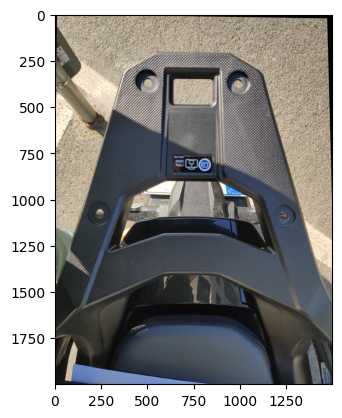

In [12]:
plt.imshow(cv2.resize(cv2.cvtColor(im_warped, cv2.COLOR_BGR2RGB), None, fx=0.5, fy=0.5))
plt.show()